In [1]:
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
from astropy.cosmology import WMAP9 as cosmo
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit, brentq
from fitting import get_phi_pd17
import fitting
from tqdm import tqdm

In [2]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k1.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]
# Calculate the fraction of data that remains
fraction_remaining = len(k_gg) / len(k['k_gg'])
print(f"Fraction of data that remained: {fraction_remaining:.2f}")

Fraction of data that remained: 1.00


In [3]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
print(d[SEL]['TARGETID'][16171])
print(d[SEL]['TARGETID'].shape)
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]

39627637697547336
(168482,)


In [4]:
bad_tid = 39627637697547336

# Create mask to exclude the target
mask_good = TARGETID != bad_tid

# Apply to all arrays
TARGETID = TARGETID[mask_good]
apr_mag_r = apr_mag_r[mask_good]
apr_mag_r_err = apr_mag_r_err[mask_good]
z_desi = z_desi[mask_good]
k_rr = k_rr[mask_good]

In [5]:
d_desi = Planck18.distmod(z_desi).value

In [6]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [7]:
def comoving_volume(z1,z2):
    """
    Calculate the comoving volume between two redshifts.
    
    Args:
        z1 (float): Lower redshift bound
        z2 (float): Upper redshift bound
    
    Returns:
        float: Comoving volume in cubic megaparsecs (Mpc^3)
    """
    #d1 = cosmo.comoving_distance(z1).value# Mpc
    #d2 = cosmo.comoving_distance(z2).value# Mpc
    return Planck18.comoving_volume(z2).value-Planck18.comoving_volume(z1).value

In [8]:
def get_phis(Ls, z,alpha,beta,phi_star,L_star):
    gamma1 = -alpha - 1
    gamma2 = -beta - 1
    #gamma1 -= 0.4
    #gamma2 += 0.1
    phis = phi_star / ((Ls / L_star) ** gamma1 + (Ls / L_star) ** gamma2)
    return phis
def get_phis_shen(Ls, zeff,phi_star,L_star,paper):
    gamma1, gamma2, _, _ = get_lfpars(paper, zeff)
    #gamma1 -= 0.4
    #gamma2 += 0.1
    phis = phi_star / ((Ls / L_star) ** gamma1 + (Ls / L_star) ** gamma2)
    return phis

In [9]:
gamma1_shen20, gamma2_shen20, L_star_shen20, phi_star_shen20 = fitting.get_lfpars_shen20(2.35)
alpha_shen20 = -(gamma1_shen20+1)
beta_shen20 = -(gamma2_shen20+1)

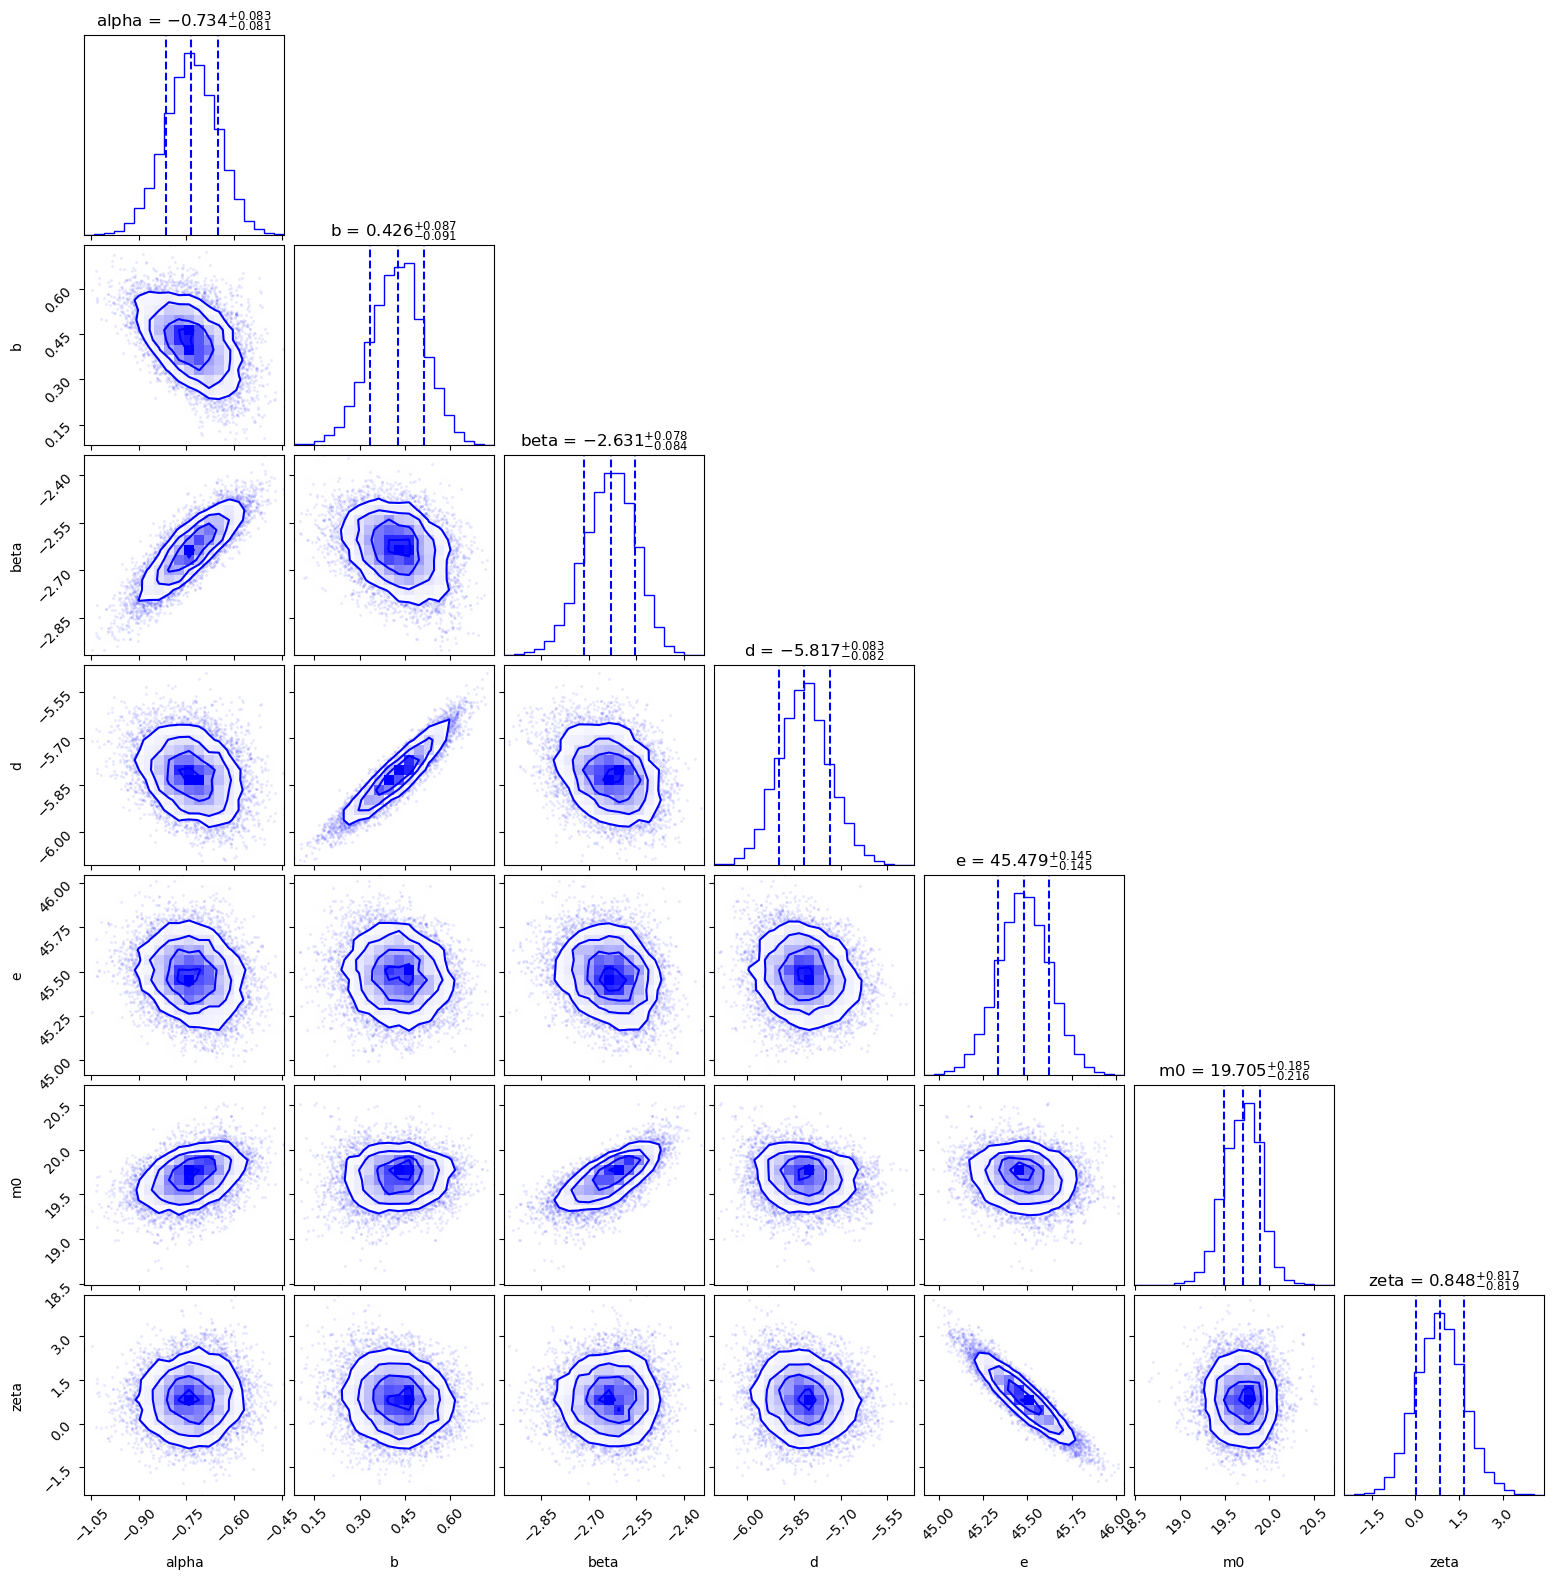

In [10]:
import corner
# Reload the uploaded MCMC sample file
samples = np.load("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples99.npz")

# Prepare the parameter matrix and labels for corner plot
param_keys = list(samples.keys())
param_matrix = np.vstack([samples[key] for key in param_keys]).T

# Generate corner plot
figure = corner.corner(
    param_matrix,
    labels=param_keys,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    color = 'blue',
    title_fmt=".3f",
    title_kwargs={"fontsize": 12}
)

plt.show()

Processing bins: 100%|██████████| 10/10 [03:45<00:00, 22.54s/it]


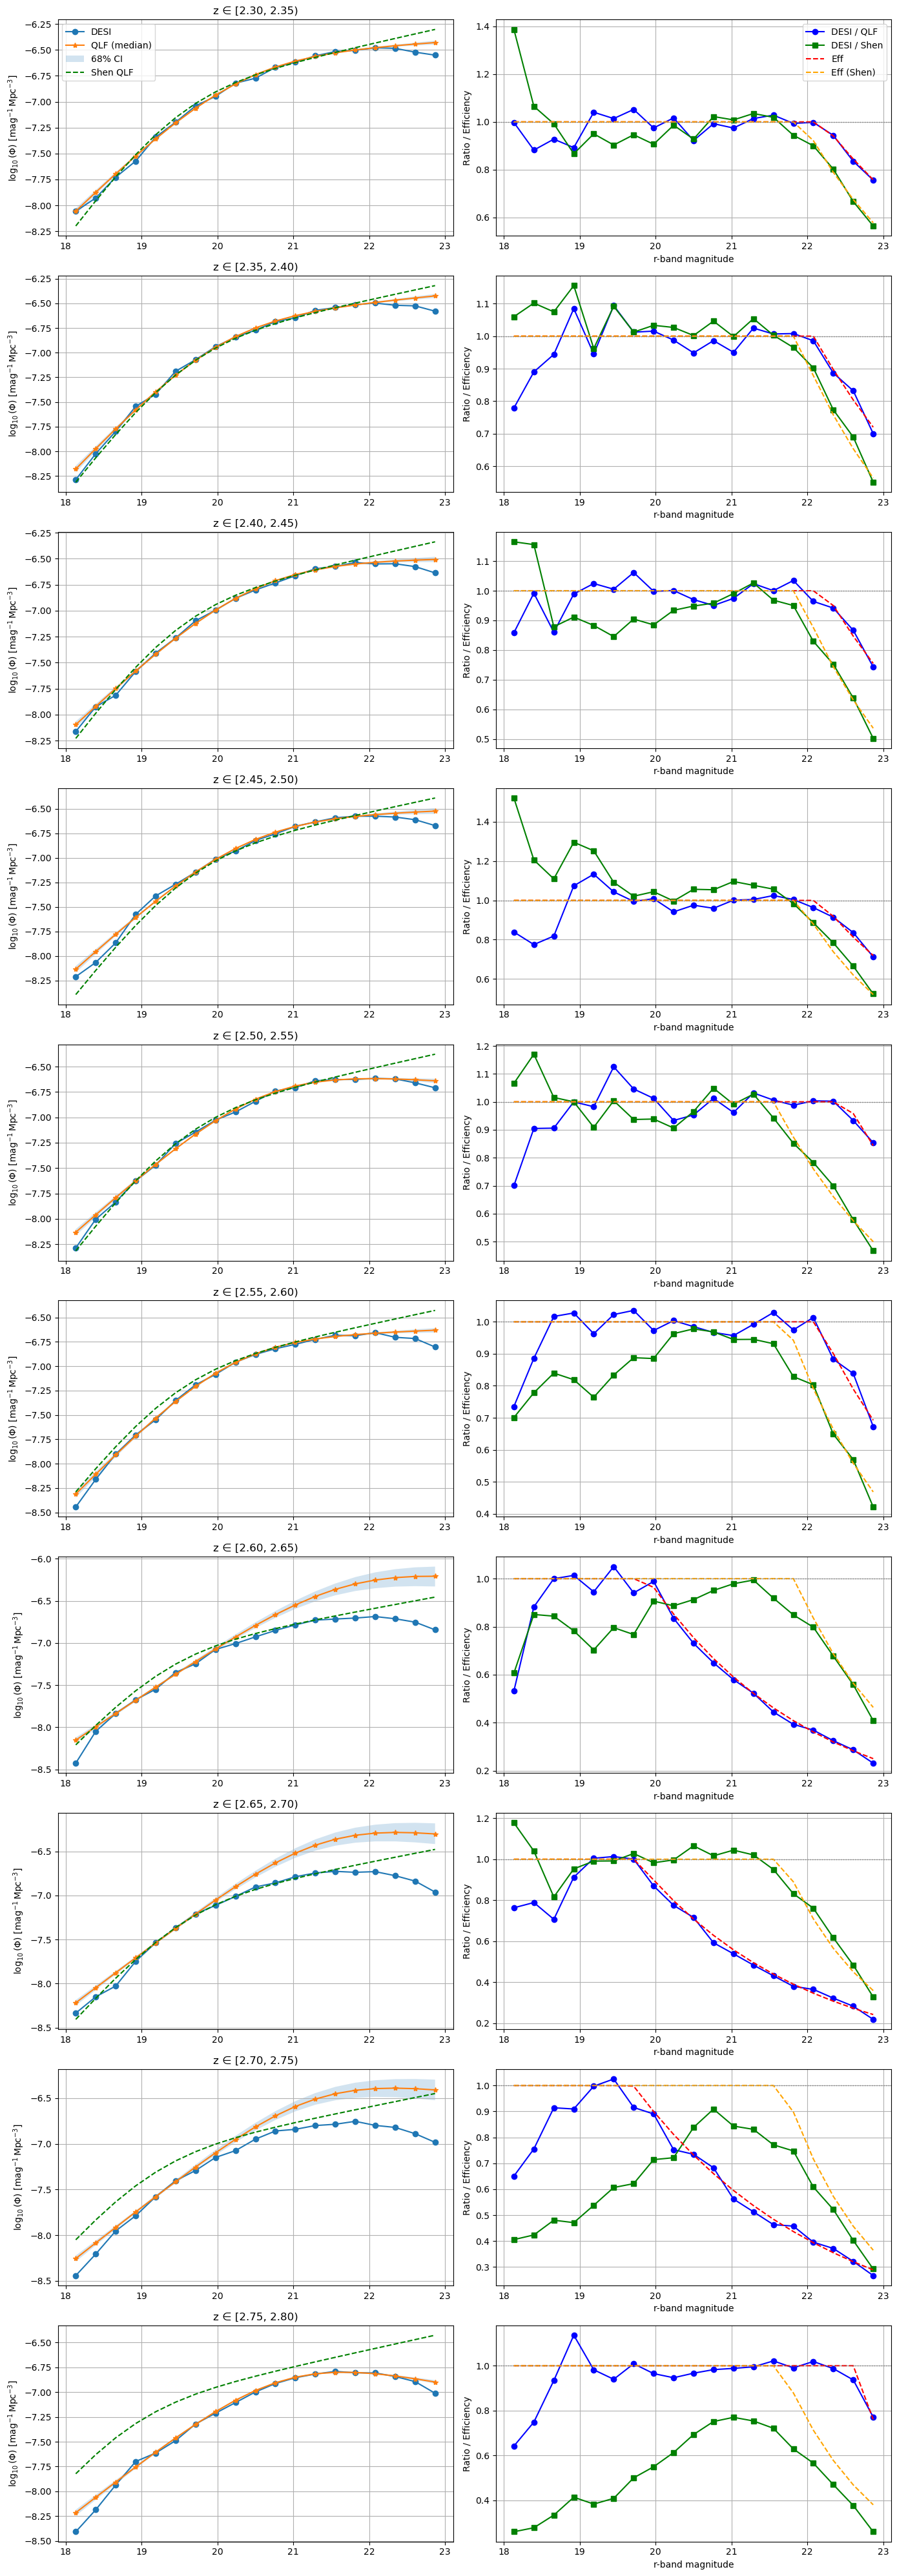

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define efficiency function
def eff(m, b, m0):
    return np.where(m < m0, 1, 10**(-b * (m - m0) / 2.5))

# File list and redshift bins
files_and_zeff = [
    ("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples11.npz", 2.325),
    ("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples22.npz", 2.375),
    ("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples33.npz", 2.425),
    ("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples44.npz", 2.475),
    ("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples55.npz", 2.525),
    ("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples66.npz", 2.575),
    ("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples77.npz", 2.625),
    ("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples88.npz", 2.675),
    ("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples99.npz", 2.725),
    ("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples00.npz", 2.775),
]

dz = 0.05  # Bin width
mag_r_bins = np.linspace(np.min(apr_mag_r), np.max(apr_mag_r), 20)
mag_r_centers = 0.5 * (mag_r_bins[:-1] + mag_r_bins[1:])
mag_r_bin_width = mag_r_bins[1] - mag_r_bins[0]

fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(14, 40))
axes = axes.reshape(10, 2)

for i, (filename, z_eff) in enumerate(tqdm(files_and_zeff, desc="Processing bins")):
    zmin = z_eff - dz / 2
    zmax = z_eff + dz / 2

    # Load MCMC samples
    samples = np.load(filename)
    shen_filename = filename.replace(".npz", "_shen.npz")
    shen_samples = np.load(shen_filename)

    # Apply mask
    mask = (z_desi > zmin) & (z_desi <= zmax)
    apr_mag_r_bin = apr_mag_r[mask]
    d_bin = d_desi[mask]
    k_rr_bin = k_rr[mask]

    if len(apr_mag_r_bin) == 0:
        axes[i, 0].set_title(f"No data in z ∈ [{zmin}, {zmax})")
        axes[i, 1].axis('off')
        continue

    counts_r, _ = np.histogram(apr_mag_r_bin, bins=mag_r_bins)
    phi_desi = counts_r / comoving_volume(zmin, zmax) / mag_r_bin_width

    # Your QLF
    N = len(samples['alpha'])
    phi_qlf_chain = np.zeros((N, len(mag_r_centers)))

    for j in range(N):
        zeta_j = samples['zeta'][j]
        abs_mag_j = mag_r_centers - np.mean(k_rr_bin) - np.mean(d_bin) + zeta_j * (z_eff - 2.3)
        L_j = abs_mag_to_L(abs_mag_j)
        phi_qlf_chain[j] = 0.4 * get_phis(L_j,
                                          z_eff,
                                          samples['alpha'][j],
                                          samples['beta'][j],
                                          10**samples['d'][j],
                                          10**samples['e'][j])

    phi_qlf_med = np.median(phi_qlf_chain, axis=0)
    phi_qlf_low = np.percentile(phi_qlf_chain, 16, axis=0)
    phi_qlf_high = np.percentile(phi_qlf_chain, 84, axis=0)

    # Shen QLF
    phi_shen_chain = np.zeros((N, len(mag_r_centers)))
    for j in range(N):
        zeta_j_shen = shen_samples['zeta'][j]
        abs_mag_j_shen = mag_r_centers - np.mean(k_rr_bin) - np.mean(d_bin) + zeta_j_shen * (z_eff - 2.3)
        L_j = abs_mag_to_L(abs_mag_j)
        phi_shen_chain[j] = 0.4 * get_phis_shen(L_j,
                                           z_eff,
                                           10**shen_samples['d'][j],
                                           10**shen_samples['e'][j],
                                               'shen20')
    phi_shen_med = np.median(phi_shen_chain, axis=0)

    # Efficiencies
    eff_yours = eff(mag_r_centers,
                    np.median(samples['b']),
                    np.median(samples['m0']))
    eff_shen = eff(mag_r_centers,
                   np.median(shen_samples['b']),
                   np.median(shen_samples['m0']))

    # Ratios
    ratio_desi_vs_qlf = phi_desi / phi_qlf_med
    ratio_desi_vs_shen = phi_desi / phi_shen_med
    #ratio_qlf_vs_shen = phi_qlf_med / phi_shen_med

    # --- Upper Panel ---
    ax0 = axes[i, 0]
    ax0.plot(mag_r_centers, np.log10(phi_desi), label='DESI', marker='o')
    ax0.plot(mag_r_centers, np.log10(phi_qlf_med), label='QLF (median)', marker='*')
    ax0.fill_between(mag_r_centers, np.log10(phi_qlf_low), np.log10(phi_qlf_high), alpha=0.2, label='68% CI')
    ax0.plot(mag_r_centers, np.log10(phi_shen_med), label='Shen QLF', linestyle='--', color='green')
    ax0.set_title(f'z ∈ [{zmin:.2f}, {zmax:.2f})')
    ax0.set_ylabel(r'$\log_{10}(\Phi)\ [\mathrm{mag}^{-1}\,\mathrm{Mpc}^{-3}]$')
    ax0.grid(True)
    if i == 0:
        ax0.legend()

    # --- Lower Panel ---
    ax1 = axes[i, 1]
    ax1.plot(mag_r_centers, ratio_desi_vs_qlf, label='DESI / QLF', color='blue', marker='o')
    ax1.plot(mag_r_centers, ratio_desi_vs_shen, label='DESI / Shen', color='green', marker='s')
    #ax1.plot(mag_r_centers, ratio_qlf_vs_shen, label='QLF / Shen', color='purple', marker='^')
    ax1.plot(mag_r_centers, eff_yours, label='Eff', color='red', linestyle='--')
    ax1.plot(mag_r_centers, eff_shen, label='Eff (Shen)', color='orange', linestyle='--')
    ax1.axhline(1, linestyle=':', color='gray', linewidth=1)
    ax1.set_ylabel('Ratio / Efficiency')
    ax1.set_xlabel('r-band magnitude')
    ax1.grid(True)
    if i == 0:
        ax1.legend()

plt.tight_layout()
plt.show()